In [49]:
import pandas as pd
import numpy as np
import ast
import missingno as msno
import seaborn as sns 
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
wlt = WordNetLemmatizer()
import gensim
from gensim import corpora
from gensim import models
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from PIL import Image
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.util import ngrams
from textblob import TextBlob
%matplotlib inline 

In [50]:
df = pd.read_csv('BA_reviews.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,reviews
0,✅ Trip Verified | On a recent flight from Cy...
1,✅ Trip Verified | Flight BA 0560 arrived in ...
2,✅ Trip Verified | This was the first time I ...
3,✅ Trip Verified | Pretty good flight but sti...
4,"✅ Trip Verified | Check in was fine, but no pr..."


In [51]:
df.columns

Index(['reviews'], dtype='object')

In [52]:
df.isna().sum()

reviews    0
dtype: int64

In [53]:
df.shape

(1000, 1)

In [54]:
# Count sentences starting with 'âœ…'
count_emoji_verified = df['reviews'].apply(lambda x: x.startswith('✅')).sum()

# Count sentences starting with 'Not Verified'
count_not_verified = df['reviews'].apply(lambda x: x.startswith('Not Verified')).sum()

# Display the counts
print(f"Sentences starting with 'âœ…': {count_emoji_verified}")
print(f"Sentences starting with 'Not Verified': {count_not_verified}")

Sentences starting with 'âœ…': 739
Sentences starting with 'Not Verified': 260


In [55]:
def process_review(review):
    if review.startswith('✅'):
        # Remove the emoji and set as verified
        return review.lstrip('✅ ').strip(), 'y'
    elif review.startswith('Not Verified'):
        # Keep as not verified
        return review, 'n'
    else:
        # Default to not verified if no match
        return review, 'h'

# Apply the processing function
df[['emoji_removed_reviews', 'trip_verified']] = df['reviews'].apply(
    lambda x: pd.Series(process_review(x))
)

df.head()

,reviews,emoji_removed_reviews,trip_verified
0,✅ Trip Verified | On a recent flight from Cy...,Trip Verified | On a recent flight from Cypr...,y
1,✅ Trip Verified | Flight BA 0560 arrived in ...,Trip Verified | Flight BA 0560 arrived in Ro...,y
2,✅ Trip Verified | This was the first time I ...,Trip Verified | This was the first time I fl...,y
3,✅ Trip Verified | Pretty good flight but sti...,Trip Verified | Pretty good flight but still...,y
4,"✅ Trip Verified | Check in was fine, but no pr...","Trip Verified | Check in was fine, but no prio...",y


In [56]:
df.trip_verified.value_counts()

trip_verified
y    739
n    260
h      1
Name: count, dtype: int64

In [57]:
weird_data = df[df.trip_verified == 'h']
print(weird_data)

                                               reviews  \
187  cNot Verified |  I had hoped this would be a g...   

                                 emoji_removed_reviews trip_verified  
187  cNot Verified |  I had hoped this would be a g...             h  


In [58]:
df.loc[df.trip_verified == 'h', 'trip_verified'] = 'n'

In [59]:
df.trip_verified.value_counts()

trip_verified
y    739
n    261
Name: count, dtype: int64

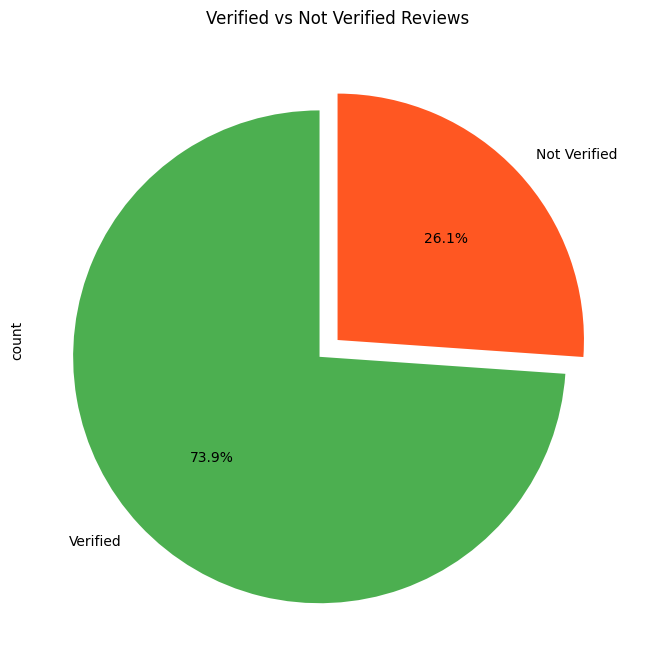

In [60]:
counts = df['trip_verified'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
counts.plot.pie(
    autopct='%1.1f%%',  # Display percentage with one decimal
    labels=['Verified', 'Not Verified'],  # Custom labels
    colors=['#4CAF50', '#FF5722'],  # Custom colors
    startangle=90,  # Start angle for better orientation
    explode=(0.1, 0)  # Slightly explode the first slice
)

# Add title
plt.title('Verified vs Not Verified Reviews')

# Display the plot
plt.show()

### Cleaning the reviews

In [61]:
df['emoji_removed_reviews'] = df['emoji_removed_reviews'].apply(lambda x: x.split('| ', 1)[1] if '| ' in x else x)
df.head()

,reviews,emoji_removed_reviews,trip_verified
0,✅ Trip Verified | On a recent flight from Cy...,On a recent flight from Cyprus BA621 on 23/1...,y
1,✅ Trip Verified | Flight BA 0560 arrived in ...,Flight BA 0560 arrived in Rome on 11 Decembe...,y
2,✅ Trip Verified | This was the first time I ...,This was the first time I flew British Airwa...,y
3,✅ Trip Verified | Pretty good flight but sti...,Pretty good flight but still some small thin...,y
4,"✅ Trip Verified | Check in was fine, but no pr...","Check in was fine, but no priority/fast track ...",y


In [62]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

import nltk
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Prajakta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prajakta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
def remove_non_english_words(sentence):
    # Define a regular expression pattern to match words containing English letters or numbers
    pattern = re.compile(r'\b[a-zA-Z0-9]+\b')
    
    # Find all words matching the pattern in the sentence
    words = pattern.findall(sentence)
    
    # Join the words back into a sentence
    filtered_sentence = ' '.join(words)
    
    return filtered_sentence

def preprocessing_review(review):
    review = remove_non_english_words(review)
    # Remove punctuation using regular expression
    review = re.sub(r'[^\w\s]', '', review)
    # Starting by tokenizing the review
    tokens = nltk.word_tokenize(review)

    # Convert all the tokens to lower case
    tokens = [tk.lower() for tk in tokens]

    # Remove all the stop words
    remove_words = stopwords.words('english')
    tokens = [tk for tk in tokens if tk not in remove_words]

    # Join the tokens back into a single string
    return ' '.join(tokens)

In [64]:
df['cleaned_reviews'] = df.emoji_removed_reviews.apply(preprocessing_review)

In [65]:
df.drop(columns=['reviews'], inplace=True)
df.head()

,emoji_removed_reviews,trip_verified,cleaned_reviews
0,On a recent flight from Cyprus BA621 on 23/1...,y,recent flight cyprus ba621 23 11 24 second cab...
1,Flight BA 0560 arrived in Rome on 11 Decembe...,y,flight ba 0560 arrived rome 11 december passen...
2,This was the first time I flew British Airwa...,y,first time flew british airways huge disappoin...
3,Pretty good flight but still some small thin...,y,pretty good flight still small things improved...
4,"Check in was fine, but no priority/fast track ...",y,check fine priority fast track lines security ...


### Sentiment analysis of tweets:

In [66]:
def get_sentiment_score(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Get the sentiment polarity
    polarity = blob.sentiment.polarity
    return polarity

# Function to get sentiment polarity
def get_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'text' column to get sentiment for each text
df['sentiment_score'] = df['cleaned_reviews'].apply(get_sentiment_score)
df['sentiment'] = df['sentiment_score'].apply(get_sentiment)

# Print the DataFrame with sentiment column
df.head()

,emoji_removed_reviews,trip_verified,cleaned_reviews,sentiment_score,sentiment
0,On a recent flight from Cyprus BA621 on 23/1...,y,recent flight cyprus ba621 23 11 24 second cab...,0.076190,Positive
1,Flight BA 0560 arrived in Rome on 11 Decembe...,y,flight ba 0560 arrived rome 11 december passen...,-0.022436,Negative
2,This was the first time I flew British Airwa...,y,first time flew british airways huge disappoin...,0.010952,Positive
3,Pretty good flight but still some small thin...,y,pretty good flight still small things improved...,0.174561,Positive
4,"Check in was fine, but no priority/fast track ...",y,check fine priority fast track lines security ...,0.125821,Positive


In [67]:
df.sentiment.value_counts()

sentiment
Positive    627
Negative    356
Neutral      17
Name: count, dtype: int64

### Textblob sentiment score doesn't seem to be accurate, thus using vaderSentiment 

In [68]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER to calculate sentiment
df['sentiment_score_vader'] = df['emoji_removed_reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Classify sentiment as Positive, Negative, or Neutral
def classify_sentiment_vader(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_vader'] = df['sentiment_score_vader'].apply(classify_sentiment_vader)

# Display the DataFrame
print(df[['emoji_removed_reviews', 'sentiment_score_vader', 'sentiment_vader']])


                                 emoji_removed_reviews  sentiment_score_vader  \
0      On a recent flight from Cyprus BA621 on 23/1...                -0.8794   
1      Flight BA 0560 arrived in Rome on 11 Decembe...                -0.8957   
2      This was the first time I flew British Airwa...                -0.9279   
3      Pretty good flight but still some small thin...                 0.9968   
4    Check in was fine, but no priority/fast track ...                 0.9808   
..                                                 ...                    ...   
995  This was the worst experience I have ever had ...                -0.7906   
996   London to Larnaca. New A321neo, 4.5 hour flig...                -0.4990   
997   Gatwick to Orlando. Excellent customer servic...                 0.2633   
998   London to Munich. The plane is A320. The seat...                 0.6688   
999   London to Glasgow. BA customer service is unq...                -0.8210   

    sentiment_vader  
0    

In [69]:
df.sentiment_vader.value_counts()

sentiment_vader
Negative    529
Positive    455
Neutral      16
Name: count, dtype: int64

In [70]:
#pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: C:\Users\Prajakta\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [72]:
df.drop(columns=['sentiment_score', 'sentiment'], inplace=True)
df.head()

,emoji_removed_reviews,trip_verified,cleaned_reviews,sentiment_score_vader,sentiment_vader
0,On a recent flight from Cyprus BA621 on 23/1...,y,recent flight cyprus ba621 23 11 24 second cab...,-0.8794,Negative
1,Flight BA 0560 arrived in Rome on 11 Decembe...,y,flight ba 0560 arrived rome 11 december passen...,-0.8957,Negative
2,This was the first time I flew British Airwa...,y,first time flew british airways huge disappoin...,-0.9279,Negative
3,Pretty good flight but still some small thin...,y,pretty good flight still small things improved...,0.9968,Positive
4,"Check in was fine, but no priority/fast track ...",y,check fine priority fast track lines security ...,0.9808,Positive


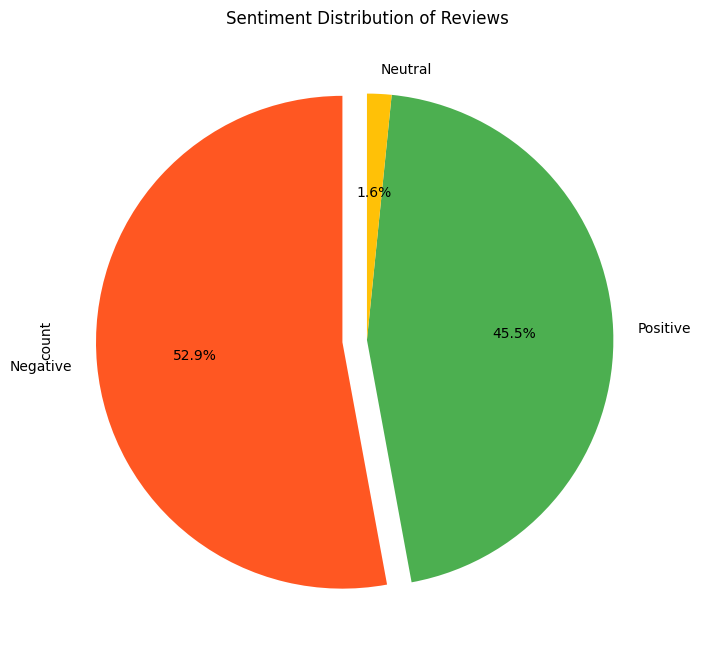

In [80]:
# Count the occurrences of each sentiment
sentiment_counts = df['sentiment_vader'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
sentiment_counts.plot.pie(
    autopct='%1.1f%%',  # Show percentages with 1 decimal place
    labels=sentiment_counts.index,  # Use sentiment labels as slice names
    colors=['#FF5722','#4CAF50','#FFC107'],  # Colors for Positive, Negative, Neutral
    startangle=90,  # Start angle for better orientation
    explode=(0.1, 0, 0) if 'Positive' in sentiment_counts.index else (0, 0.1, 0)  # Highlight a slice
)

# Add title
plt.title('Sentiment Distribution of Reviews')

# Display the pie chart
plt.show()

## Topic Modelling

### 1. KMeans & TFIDF

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Step 2: Tokenization and Vectorization
def kmeans_topic_modelling(corpus_kmeans):
    # Step 2: Tokenization and Vectorization
    stop_words = ['british', 'airways', 'british airways', 'ba', 'flight']  # Specify the words to remove
    vectorizer = TfidfVectorizer(lowercase=True, max_features=100, max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words=stop_words)
    vectors = vectorizer.fit_transform(corpus_kmeans)
    
    # Step 3: Apply KMeans with KMeans++ initialization
    model = KMeans(n_clusters = 3, init= 'k-means++',n_init=1, random_state=42)
    
    model.fit(vectors)
    
    # Get the centroids
    centroids = model.cluster_centers_
    
    # Sort the centroids indices
    order_centroids = centroids.argsort()[:, ::-1]
    
    # Get the feature names
    terms = vectorizer.get_feature_names_out()
    for i in range(3):
        print(f"Topic {i}:")
        top_terms = [terms[ind] for ind in order_centroids[i, :10]]
        print(top_terms)

kmeans_topic_modelling(df['cleaned_reviews'])

Topic 0:
['class', 'business', 'business class', 'seat', 'seats', 'economy', 'food', 'service', 'first', 'one']
Topic 1:
['crew', 'good', 'food', 'cabin', 'time', 'service', 'cabin crew', 'seat', 'seats', 'club']
Topic 2:
['customer', 'service', 'cancelled', 'london', 'us', 'hours', 'luggage', 'customer service', 'airline', 'get']


#### 2. NFM & TF-IDF

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


def nfm_topic_modelling(corpus_nfm):
    # Step 2: Tokenization and Vectorization
    stop_words = ['british', 'airways', 'british airways', 'ba', 'flight']  # Specify the words to remove
    tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=6, stop_words=stop_words ,max_features = 100,)
    tfidf = tfidf_vectorizer.fit_transform(corpus_nfm)
    
    # Step 3: Apply NMF
    num_topics = 3  # Specify the number of topics
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_model.fit(tfidf)
    
    # Step 4: Interpret the Topics
    feature_names = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic {topic_idx}:", ", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

nfm_topic_modelling(df['cleaned_reviews'])

Topic 0: good, crew, cabin, food, time, club, service, boarding, lounge, great
Topic 1: us, customer, hours, cancelled, told, get, london, service, airport, airline
Topic 2: class, business, seat, seats, economy, premium, first, one, food, poor


## Word cloud Generation

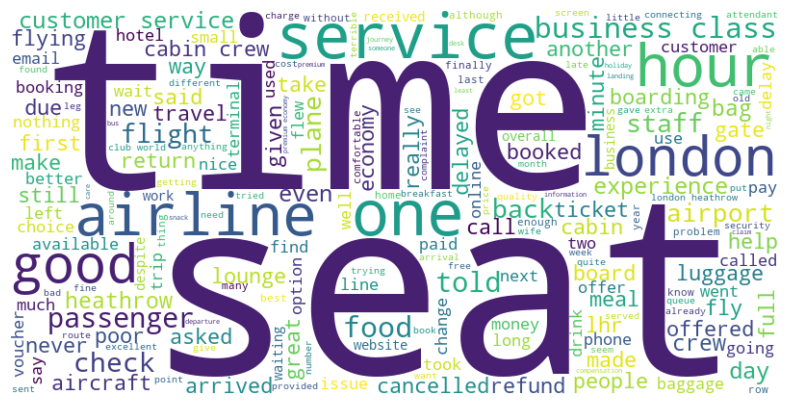

In [87]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

stopword = ['british', 'airways', 'british airways', 'ba', 'flight'] # Specify the words to remove
def preprocess_tweets(customer):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for tweets in customer['cleaned_reviews']:
        words = [w for w in word_tokenize(tweets) if (w not in stopword)]

        words = [lem.lemmatize(w) for w in words if len(w) > 2]

        corpus.append(words)
    return corpus

def remove_specific_words(corpus, words_to_remove):
    filtered_corpus = []
    for document in corpus:
        filtered_document = [word for word in document if word not in words_to_remove]
        filtered_corpus.append(filtered_document)
    return filtered_corpus

def generate_wordCloud(corpus_lda):
    words_to_remove = ['https', 'co']
        
    # Assuming `influencer_corpus` is a list of lists of words representing your text data
    corpus_lda = remove_specific_words(corpus_lda, words_to_remove)
    
    # Flatten the list of lists into a single list of words
    flat_corpus_lda = [word for sublist in corpus_lda for word in sublist]
    
    # Combine all text into a single string
    text = ' '.join(flat_corpus_lda)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(text)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

corpus_lda = preprocess_tweets(df)
generate_wordCloud(corpus_lda)